## Count terms appearing in tweets

In [23]:
import gzip
import json
import os
import re

DATADIR = "../data/rivm/"

In [18]:
TEXT = "text"
FULLTEXT = "full_text"
EXTENDEDTWEET = "extended_tweet"
RETWEETEDSTATUS = "retweeted_status"

def getTweetText(jsonData):
    text = ""
    if TEXT in jsonData: 
        text = jsonData[TEXT]
    if EXTENDEDTWEET in jsonData and \
       FULLTEXT in jsonData[EXTENDEDTWEET]:
        text = jsonData[EXTENDEDTWEET][FULLTEXT]
    if RETWEETEDSTATUS in jsonData and \
       EXTENDEDTWEET in jsonData[RETWEETEDSTATUS] and \
       FULLTEXT in jsonData[RETWEETEDSTATUS][EXTENDEDTWEET]:
        text = jsonData[RETWEETEDSTATUS][EXTENDEDTWEET][FULLTEXT]
    return(text)

In [89]:
from datetime import datetime, timedelta

DATEFORMAT = "%a %b %d %H:%M:%S %z %Y"
SUMMERTIMEDATE = datetime.strptime("Sun Mar 29 02:00:00 +0000 2020",DATEFORMAT)
WINTERTIMEDATE = datetime.strptime("Sun Oct 25 03:00:00 +0000 2020",DATEFORMAT)

def getTweetDate(jsonData):
    dateString = jsonData["created_at"]
    dateData = datetime.strptime(dateString,DATEFORMAT)+timedelta(hours=1)
    if dateData >= SUMMERTIMEDATE:
        if dateData >= WINTERTIMEDATE: sys.exit("cannot happen")
        dateData += timedelta(hours=1)
    return(dateData.strftime("%Y%m%d"))

In [107]:
fileNames = os.listdir(DATADIR)

def search(query):
    counts = {}
    for inFileName in fileNames:
        inFile = gzip.open(DATADIR+inFileName,mode="rt")
        for line in inFile:
            jsonData = json.loads(line)
            tweetText = getTweetText(jsonData)
            tweetDate = getTweetDate(jsonData)
            if re.search(query,tweetText,flags=re.IGNORECASE):
                if tweetDate in counts: counts[tweetDate] += 1
                else: counts[tweetDate] = 1
        inFile.close()
    counts = {k:v for k, v in sorted(counts.items(), key=lambda item: item[0])}
    return(counts)

In [108]:
rivm = search("rivm")
corona = search("corona")
covid = search("covid")

### Plot absolute values

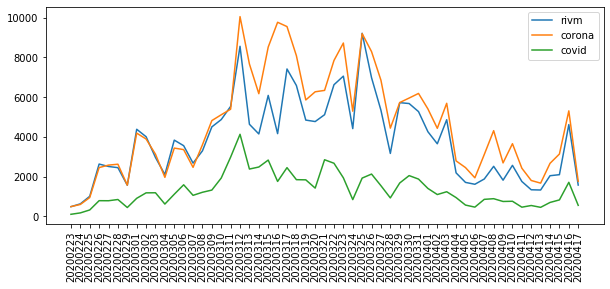

In [157]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
ax1 = plt.subplot(111)
plt.xticks(rotation="vertical")
ax1.plot_date(rivm.keys(),rivm.values(),xdate=True,fmt="-",label="rivm")
ax1.plot_date(corona.keys(),corona.values(),xdate=True,fmt="-",label="corona")
ax1.plot_date(covid.keys(),covid.values(),xdate=True,fmt="-",label="covid")
dummy = ax1.legend()

### Plot normalized values

In [164]:
import pandas as pd

def normalize(dateCounts,countsIn):
    countsOut = {}
    for key in countsIn:
        if int(key) in dateCounts.index: 
            countsOut[key] = countsIn[key]/dateCounts.loc[int(key)]["count"]
    return(countsOut)

dateCounts = pd.read_csv(DATADIR+"../date-counts.csv",index_col=["date"])

In [165]:
rivmNorm = normalize(dateCounts,rivm)
coronaNorm = normalize(dateCounts,corona)
covidNorm = normalize(dateCounts,covid)

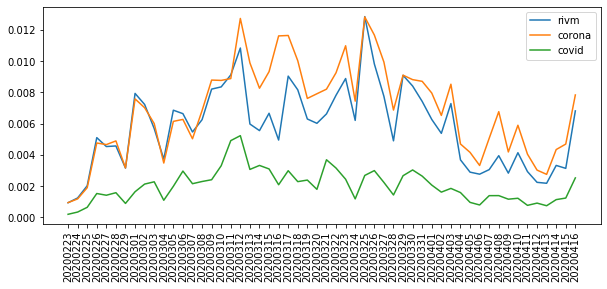

In [166]:
plt.figure(figsize=(10,4))
ax2 = plt.subplot(111)
plt.xticks(rotation="vertical")
ax2.plot_date(rivmNorm.keys(),rivmNorm.values(),xdate=True,fmt="-",label="rivm")
ax2.plot_date(coronaNorm.keys(),coronaNorm.values(),xdate=True,fmt="-",label="corona")
ax2.plot_date(covidNorm.keys(),covidNorm.values(),xdate=True,fmt="-",label="covid")
dummy = ax2.legend()